In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.9.0+cu102].
device:[cuda:0].


In [11]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
BATCH_SIZE =256
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
print ("Done.")

Done.


In [12]:
class RecurrentNeuralNetworkClass(nn.Module):
  def __init__(self,name='rnn',xdim=28,hdim=256,ydim=10,n_layer=3):
    super(RecurrentNeuralNetworkClass,self).__init__()
    self.name = name
    self.xdim = xdim
    self.hdim = hdim
    self.ydim= ydim
    self.n_layer = n_layer 

    self.rnn = nn.LSTM(input_size=self.xdim,hidden_size=self.hdim,num_layers=self.n_layer,batch_first=True)
    self.lin = nn.Linear(self.hdim,self.ydim)

  def forward(self,x):
    # Set initial hidden and cell states
    h0 = torch.zeros(self.n_layer,x.size(0),self.hdim).to(device)
    c0 = torch.zeros(self.n_layer,x.size(0),self.hdim).to(device)

    # RNN
    rnn_out, (hn,cn) = self.rnn(x,(h0,c0))

    out = self.lin(rnn_out[:,-1 :]).view([-1,self.ydim])
    return out

R = RecurrentNeuralNetworkClass(name='rnn',xdim=28,hdim=256,ydim=10,n_layer=2).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(R.parameters(),lr=1e-3)
print("Done")


Done


In [4]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy = np.random.rand(2,10,28)
x_torch = torch.from_numpy(x_numpy).float().to(device)
rnn_out, (hn,cn) = R.rnn(x_torch)

print("rnn_out:", rnn_out.shape)
print("Hidden State hn:", hn.shape)
print("Cell States cn:", cn.shape)


rnn_out: torch.Size([2, 10, 256])
Hidden State hn: torch.Size([2, 2, 256])
Cell States cn: torch.Size([2, 2, 256])


>**Check params**

In [5]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx, (param_name,param) in enumerate(R.named_parameters()):
  if param.requires_grad:
    param_numpy = param.detach().cpu().numpy()
    n_param += len(param_numpy.reshape(-1))
    print("[%d] name:[%s] shape:[%s]"%(p_idx,param_name,param_numpy.shape))
    print("    val:%s"%(param_numpy.reshape(-1)[:5]))
print("Total number of parameters:[%s]"%(format(n_param,',d')))


[0] name:[rnn.weight_ih_l0] shape:[(1024, 28)]
    val:[-0.06   0.026 -0.021  0.042 -0.005]
[1] name:[rnn.weight_hh_l0] shape:[(1024, 256)]
    val:[ 0.041  0.023 -0.021  0.03   0.043]
[2] name:[rnn.bias_ih_l0] shape:[(1024,)]
    val:[ 0.025 -0.061 -0.036 -0.036  0.018]
[3] name:[rnn.bias_hh_l0] shape:[(1024,)]
    val:[-0.031  0.047 -0.033 -0.035 -0.042]
[4] name:[rnn.weight_ih_l1] shape:[(1024, 256)]
    val:[ 0.059 -0.02  -0.06  -0.047  0.031]
[5] name:[rnn.weight_hh_l1] shape:[(1024, 256)]
    val:[-0.058  0.037 -0.035  0.018 -0.033]
[6] name:[rnn.bias_ih_l1] shape:[(1024,)]
    val:[ 0.012  0.009  0.016  0.03  -0.039]
[7] name:[rnn.bias_hh_l1] shape:[(1024,)]
    val:[ 0.023  0.025 -0.018 -0.05   0.055]
[8] name:[lin.weight] shape:[(10, 256)]
    val:[-0.002  0.046 -0.002  0.061 -0.058]
[9] name:[lin.bias] shape:[(10,)]
    val:[-0.051 -0.008  0.027  0.016 -0.055]
Total number of parameters:[821,770]


> **Simple Forward Path**

In [6]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy = np.random.rand(3,10,28) # [N x L x Q]
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = R.forward(x_torch)
y_numpy = y_torch.detach().cpu().numpy()
print("x_numpy %s"%(x_numpy.shape,))
print("y_numpy %s"%(y_numpy.shape,))


x_numpy (3, 10, 28)
y_numpy (2, 10)


>**Evaluation Function**

In [7]:
def func_eval(model,data_iter,device):
  with torch.no_grad():
    n_total,n_correct = 0, 0
    model.eval()
    for batch_in, batch_out in data_iter:
      y_trgt = batch_out.to(device)
      model_pred = model.forward(batch_in.view(-1,28,28).to(device))
      _, y_pred = torch.max(model_pred,1)
      n_correct += (y_pred==y_trgt).sum().item()
      n_total += batch_in.size(0)
    
    val_accr = (n_correct/n_total)
    model.train()
  return val_accr
print("Done")

Done


>**Initial Evaluation**

In [13]:
train_accr = func_eval(R, train_iter, device)
test_accr = func_eval(R, test_iter, device)
print("train_accr:[%.3f] test_accr:[%.3f]"%(train_accr,test_accr))


train_accr:[0.097] test_accr:[0.098]


>**Train**

In [15]:
print("Start training.")
R.train()
EPOCHS, print_every = 10, 1
for epoch in range(EPOCHS):
  loss_val_sum = 0
  for batch_in, batch_out in train_iter:
    #Forward Path
    y_pred = R.forward(batch_in.view(-1,28,28).to(device))
    loss_out = loss(y_pred,batch_out.to(device))

    optm.zero_grad()
    loss_out.backward()
    optm.step()
    loss_val_sum += loss_out
  loss_val_avg = loss_val_sum/len(train_iter)
  # Print
  if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
    train_accr = func_eval(R,train_iter,device)
    test_accr = func_eval(R, test_iter, device)
    print("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]"%(epoch, loss_val_avg, train_accr, test_accr))
print("DONE")

Start training.
epoch:[0] loss:[0.144] train_accr:[0.963] test_accr:[0.961]
epoch:[1] loss:[0.091] train_accr:[0.981] test_accr:[0.977]
epoch:[2] loss:[0.063] train_accr:[0.984] test_accr:[0.981]
epoch:[3] loss:[0.049] train_accr:[0.989] test_accr:[0.984]
epoch:[4] loss:[0.038] train_accr:[0.990] test_accr:[0.985]
epoch:[5] loss:[0.035] train_accr:[0.989] test_accr:[0.984]
epoch:[6] loss:[0.029] train_accr:[0.992] test_accr:[0.987]
epoch:[7] loss:[0.028] train_accr:[0.992] test_accr:[0.985]
epoch:[8] loss:[0.022] train_accr:[0.990] test_accr:[0.985]
epoch:[9] loss:[0.021] train_accr:[0.995] test_accr:[0.988]
DONE


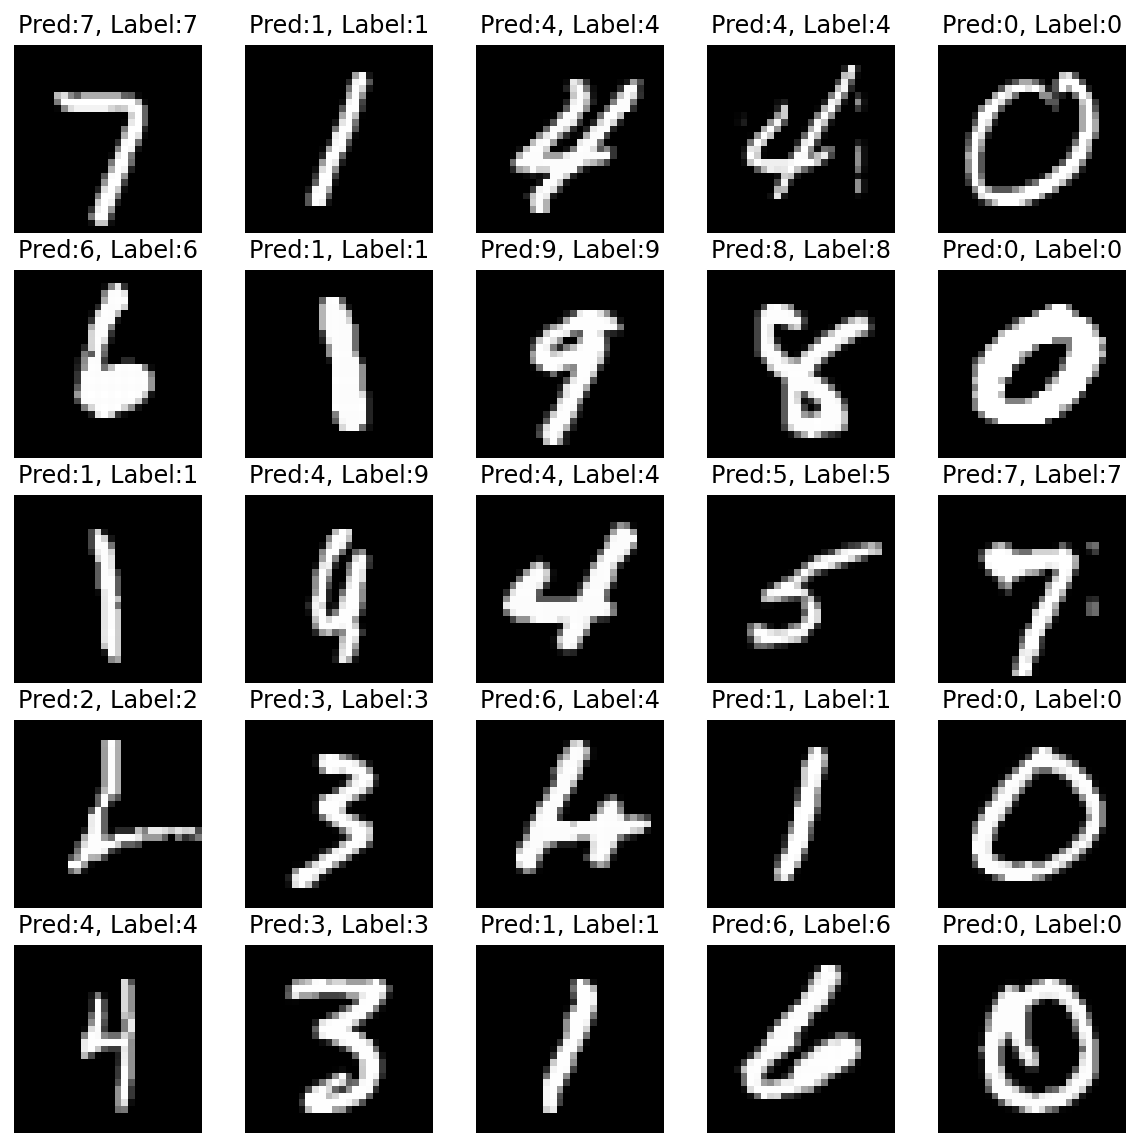

Done


In [16]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets),n_sample,replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]
with torch.no_grad():
    R.eval() # to evaluation mode 
    y_pred = R.forward(test_x.view(-1,28,28).type(torch.float).to(device)/255.)
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))
plt.show()
print ("Done")